# Dataset analysis

In this notebook, I collect insights from the data I collected. This notebook will be updated constantly as I add more and more data sources.

At the time of writing this (15th July 2023), this included the following data, obtained with corresponding Python scripts in the `cli-scripts` folder:

- Charts data from 1st January 2017 up until 30th June 2023 (`get_charts.py` followed by `combine_charts.py`)
- Track, Artist, and Album metadata collected from the Spotify API stored in corresponding subfolders (obtained with `spotify_api/get_all.py`)
- Track credits and (incomplete) lyrics metadata for tracks that were retrieved from an internal Spotify API through some 'hacks' (`use_internal_spotify_apis.py`)

In [1]:
import pandas as pd
from helpers.data import (
    create_data_path,
    write_series_to_file_as_prettified_json,
    write_dict_to_file_as_prettified_json,
    load_parquet_files_in_dir,
    convert_columns_to_snake_case
)
from helpers.spotify_util import (
    create_spotipy_client,
    get_spotify_track_link,
    get_id_from_spotify_uri,
)
from helpers.util import split_into_chunks_of_size
import os
from tqdm import tqdm

In [2]:
data_folder = create_data_path("top200_01-2017_06-2023")

In [3]:
spotify = create_spotipy_client() # will be used later to verify/validate data we collected

## Charts data

In [4]:
charts_data_path = os.path.join(data_folder, "charts.parquet")
charts_data = pd.read_parquet(charts_data_path)
charts_data.head()

,date,region_code,track_id,pos,artist_names,track_name,source,peak_rank,previous_rank,days_on_chart,streams
0,2017-01-01,AR,6mICuAdrwEjh6Y6lroV2Kg,1,"Shakira, Maluma",Chantaje (feat. Maluma),Sony Music Latin,1,-1,1,253019
1,2017-01-01,AR,7DM4BPaS7uofFul3ywMe46,2,"Ricky Martin, Maluma",Vente Pa' Ca (feat. Maluma),Sony Music Latin,2,-1,1,223988
2,2017-01-01,AR,3AEZUABDXNtecAOSC1qTfo,3,CNCO,Reggaetón Lento (Bailemos),Sony Music Latin,3,-1,1,210943
3,2017-01-01,AR,6rQSrBHf7HlZjtcMZ4S4bO,4,"J Balvin, Pharrell Williams, BIA, Sky Rompiendo",Safari,UMLE - Latino,4,-1,1,173865
4,2017-01-01,AR,58IL315gMSTD37DOZPJ2hf,5,Daddy Yankee,Shaky Shaky,El Cartel Records (EC3),5,-1,1,153956


## Track data

In [5]:
track_data_dir =  os.path.join(data_folder, "tracks")
track_df_dict = load_parquet_files_in_dir(track_data_dir)
track_df_dict.keys()

dict_keys(['artists', 'markets', 'metadata'])

### Metadata

In [6]:
track_metadata = track_df_dict['metadata']
track_metadata.head()

,disc_number,duration_ms,explicit,name,preview_url,track_number,isrc,album_id
track_id,,,,,,,,
6mICuAdrwEjh6Y6lroV2Kg,1,195840,False,Chantaje (feat. Maluma),https://p.scdn.co/mp3-preview/1b18b5e5619d1db1...,3,USSD11600299,6bUxh58rYTL67FS8dyTKMN
7DM4BPaS7uofFul3ywMe46,1,259195,False,Vente Pa' Ca (feat. Maluma),https://p.scdn.co/mp3-preview/ecddab17cc70b189...,1,USSD11600252,1FkaJUwfqLdQdSmRPBlw6l
3AEZUABDXNtecAOSC1qTfo,1,222560,False,Reggaetón Lento (Bailemos),https://p.scdn.co/mp3-preview/71b0d8200a5b1f85...,3,USSD11600135,0YLrAWUbY0nyM7PFtqnYld
6rQSrBHf7HlZjtcMZ4S4bO,1,205600,False,Safari,None,3,USUM71604778,2LYwooMTH1iJeBvWyXXWUf
58IL315gMSTD37DOZPJ2hf,1,234320,False,Shaky Shaky,None,1,US2BU1600020,2zrLk90b4qjmrxRZKyIY7X


In [7]:
track_metadata.index.nunique()

163454

In [8]:
assert track_metadata.shape[0] == track_metadata.index.nunique()

In [9]:
track_metadata.isrc.isna().sum()

35

The [ISRC](https://en.wikipedia.org/wiki/International_Standard_Recording_Code) is available for almost all tracks! That is convenient, as this _international standardized recoding code_ could be used to obtain further metadata, e.g. from MusicBrainz.

### Track markets

In [10]:
track_markets = track_df_dict['markets']
track_markets.head()

,market
track_id,
6mICuAdrwEjh6Y6lroV2Kg,AR
6mICuAdrwEjh6Y6lroV2Kg,AU
6mICuAdrwEjh6Y6lroV2Kg,AT
6mICuAdrwEjh6Y6lroV2Kg,BE
6mICuAdrwEjh6Y6lroV2Kg,BO


In [11]:
track_markets.index.nunique()

123262

In [12]:
assert track_markets.index.nunique() < track_metadata.shape[0]

In [13]:
track_metadata.shape[0] - track_markets.index.nunique()

40192

That's interesting, market information seems to be missing for quite a few tracks in the dataset?

In [14]:
# get IDs of tracks that are in the metadata but not in the markets
missing_track_ids = track_metadata.index.difference(track_markets.index)
missing_track_ids

Index(['003Tf4XVKCg6tFSv7JKgfz', '003WZkrHUL3u1uAr5ZMJxZ',
       '004nEmGTeP5Mus4qXxz3x2', '004zGvrc84enQHFitC6auy',
       '005oYmIDkyY7FjhNhcfGkv', '006LuHbY5Tt9dhbdSOnVq6',
       '007QSAaELpVxtX5Z6dMn0U', '007S8LPHyug4UrgDWxiCxO',
       '007d7JT41sSc1HqWTs4uw7', '007ogFejDqJKzEXDUDF8Nf',
       ...
       '7zsSUjNwsJ2WUZfLesfkEK', '7ztlf9mCrjoLXAYYf0LCYx',
       '7zuxN6mJ6Wc27TXfQ6GPZL', '7zvfDihYiJ8RQ1nRcpKBF5',
       '7zwO9KmNWzxKJj3wBdUXL5', '7zxd3J5hMPeLN71VS8vnE4',
       '7zyWKLsmcHObOAXoBaOo5o', '7zzI3SbctTJN6wDerZNZCD',
       '7zzbnhCpuuHOCrhBGvgwpp', '7zzhRAobAnNjarw2FAWt65'],
      dtype='object', name='track_id', length=40192)

Does the Spotify API really not return any market data for those tracks?

To verify that, we need to understand how to obtain the market information from each API response (using `spotipy`, which is the wrapper for the Spotify API that was also used for getting the data initially):

In [15]:
example_track_markets = spotify.track(missing_track_ids[0])['available_markets']
example_track_markets

[]

We see that for the example, the response is indeed empty. We can write an assertion to test that for other cases. It will throw an `AssertionError` if it is not fulfilled.

In [16]:
def check_for_no_available_markets(api_track_response, track_id):
    assert api_track_response["available_markets"] == [], f"available_markets is not empty for track_id: {track_id}"

In [17]:
# demo: check for single track
check_for_no_available_markets(spotify.track(missing_track_ids[0]), missing_track_ids[0])

In [18]:
# demo: check for multiple tracks at once
for api_response, track_id in zip(spotify.tracks(missing_track_ids[:2])["tracks"], missing_track_ids[:2]):
    check_for_no_available_markets(api_response, track_id)

Let's test this for all the IDs we have obtained. If a few IDs happen to be available, we will not change anything about our dataset (the data in the Spotify API changes all the time anyway).

In [19]:
# check for all (commented out to avoid spamming Spotify API with 40k tracks every time this notebook is run)
track_id_chunks = split_into_chunks_of_size(missing_track_ids, 50) # max. 50 tracks per request

# ids_with_available_markets = []
# for track_ids in tqdm(track_id_chunks):
#     for api_response, track_id in zip(spotify.tracks(track_ids)["tracks"], track_ids):
#         try:
#             check_for_no_available_markets(api_response, track_id)
#         except AssertionError:
#             ids_with_available_markets.append(track_id)

# len(ids_with_available_markets)

To save us from getting blocked by the Spotify API (making requests with over 40k tracks repeatedly is probably a bit problematic), I have commented out the code cell above. However, the output when I ran this on 16th of July 2023 was:

![Output of unavailable track markets check](./images/screenshot-track-markets-check.jpg)

I.e., only for 4 IDs where our collected market data is empty, the available markets API response was non-empty. It's absolutely NOT worth recreating the dataset for 4 IDs lol

But still, it would be interesting to know why such a substantial portion of tracks (roughly 40k out of the total 160k) is apparently currently not available anywhere 🤔

My hypothesis is that many tracks are just re-released later and the old version is taken down from Spotify. We could verify this by collecting track IDs that are associated with the same physical recording, identified via the ISRC.

In [20]:
# TODO: check hypothesis outlined from above

In [21]:
track_markets.market.value_counts()

NO    117790
FI    117685
DK    117644
CW    117595
DE    117472
       ...  
LY    115054
CD    115038
BF    115036
BN    115020
BY    104587
Name: market, Length: 184, dtype: int64

In [22]:
track_artists = track_df_dict['artists']
track_artists.head()

,artist_id,pos
track_id,,
6mICuAdrwEjh6Y6lroV2Kg,0EmeFodog0BfCgMzAIvKQp,1
6mICuAdrwEjh6Y6lroV2Kg,1r4hJ1h58CWwUQe3MxPuau,2
7DM4BPaS7uofFul3ywMe46,7slfeZO9LsJbWgpkIoXBUJ,1
7DM4BPaS7uofFul3ywMe46,1r4hJ1h58CWwUQe3MxPuau,2
3AEZUABDXNtecAOSC1qTfo,0eecdvMrqBftK0M1VKhaF4,1


In [23]:
assert track_artists.index.nunique() == track_metadata.shape[0] # an artist entry should exist in our collected data for every track

<Axes: title={'center': 'Number of participating artists in tracks in the top 200'}>

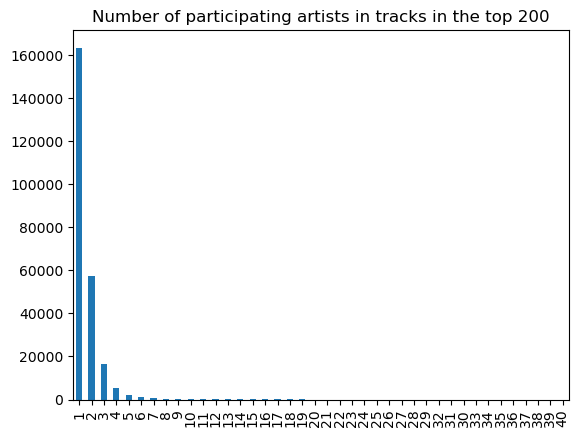

In [24]:
track_artists.pos.value_counts().plot(kind='bar', title='Number of participating artists in tracks in the top 200')

The vast majority of chart hits are performed by a single artist.

## Album Data

In [25]:
album_data_dir =  os.path.join(data_folder, "albums")
album_df_dict = load_parquet_files_in_dir(album_data_dir)
album_df_dict.keys()
    

dict_keys(['copyrights', 'artists', 'markets', 'imgs', 'metadata'])

### Metadata

In [26]:
album_metadata = album_df_dict['metadata']
album_metadata.head()

,album_type,label,name,release_date,release_date_precision,total_tracks,upc,amgid
album_id,,,,,,,,
6bUxh58rYTL67FS8dyTKMN,album,Sony Music Latin,El Dorado,2017-05-26,day,13,886446480060,None
1FkaJUwfqLdQdSmRPBlw6l,single,Sony Music Latin,Vente Pa' Ca (feat. Maluma),2016-09-22,day,1,886446092928,None
0YLrAWUbY0nyM7PFtqnYld,album,Sony Music Latin,Primera Cita,2016-08-26,day,14,886445722550,None
2LYwooMTH1iJeBvWyXXWUf,album,Universal Music Group,Energía,2016-06-24,day,15,00602547952387,None
2zrLk90b4qjmrxRZKyIY7X,single,Universal Music Group,Shaky Shaky,2016-04-08,day,1,00602547885456,None


In [27]:
album_metadata.label.value_counts().sort_values(ascending=False)[:10]

Sony Music Entertainment       2323
Universal Music Group          1778
Columbia                       1518
WM Finland                     1473
Universal Music Oy             1196
RCA Records Label               949
Universal Music Italia srL.     745
Universal Music AB              722
Universal Music A/S             676
WM Sweden                       622
Name: label, dtype: int64

In [28]:
album_metadata.release_date.min()

Timestamp('1840-06-14 00:00:00')

### Artists

In [29]:
album_artists = album_df_dict['artists']
album_artists.pos.value_counts()

1    103247
2     22749
3      6089
4         9
5         6
Name: pos, dtype: int64

In [30]:
album_artists.head()

,artist_id,pos
album_id,,
6bUxh58rYTL67FS8dyTKMN,0EmeFodog0BfCgMzAIvKQp,1
1FkaJUwfqLdQdSmRPBlw6l,7slfeZO9LsJbWgpkIoXBUJ,1
0YLrAWUbY0nyM7PFtqnYld,0eecdvMrqBftK0M1VKhaF4,1
2LYwooMTH1iJeBvWyXXWUf,1vyhD5VmyZ7KMfW5gqLgo5,1
2zrLk90b4qjmrxRZKyIY7X,4VMYDCV2IEDYJArk749S6m,1


In [31]:
album_copyrights = album_df_dict['copyrights']
album_copyrights.head()

,text,type
album_id,,
6bUxh58rYTL67FS8dyTKMN,(P) 2016 Wati-B under exclusive license to Son...,P
1FkaJUwfqLdQdSmRPBlw6l,(P) 2016 Sony Music Entertainment US Latin LLC,P
0YLrAWUbY0nyM7PFtqnYld,(P) 2016 Sony Music Entertainment US Latin LLC,P
2LYwooMTH1iJeBvWyXXWUf,© 2016 Capitol Latin,C
2LYwooMTH1iJeBvWyXXWUf,℗ 2016 Capitol Latin,P


In [32]:
album_copyrights.index.nunique()

102945

In [33]:
album_copyrights.type.value_counts()

P    100848
C     86522
Name: type, dtype: int64

In [34]:
album_copyrights.text.value_counts().sort_values(ascending=False)[:10]

2019 Super Cassettes Industries Private Limited                                                                    252
© 2018 Universal Music Spain S.L.U./ Gestmusic Endemol, SAU/ Radio Televisión Española, Sociedad Anónima S.M.E.    184
℗ 2018 Universal Music Spain S.L.U./ Gestmusic Endemol, SAU/ Radio Televisión Española, Sociedad Anónima S.M.E.    181
NMC United Entertainment Ltd.                                                                                      176
2020 Super Cassettes Industries Private Limited                                                                    152
© 2017 Warner Music Finland                                                                                        145
Music Nation Records Co. Ltd.                                                                                      144
℗ 2017 Warner Music Finland                                                                                        144
© 2019 Warner Music Finland                     

In [35]:
album_markets = album_df_dict['markets']
album_markets.head()

,market
album_id,
6bUxh58rYTL67FS8dyTKMN,AD
6bUxh58rYTL67FS8dyTKMN,AE
6bUxh58rYTL67FS8dyTKMN,AG
6bUxh58rYTL67FS8dyTKMN,AL
6bUxh58rYTL67FS8dyTKMN,AM


In [36]:
album_markets.market.value_counts()

NO    73709
FI    73614
DK    73563
CW    73520
DE    73481
      ...  
IQ    72015
LY    71940
CD    71891
US    71870
BY    65775
Name: market, Length: 184, dtype: int64

In [37]:
album_imgs = album_df_dict['imgs']
album_imgs.head()

,url,width,height
album_id,,,
6bUxh58rYTL67FS8dyTKMN,https://i.scdn.co/image/ab67616d0000b273d05d3a...,640,640
6bUxh58rYTL67FS8dyTKMN,https://i.scdn.co/image/ab67616d00001e02d05d3a...,300,300
6bUxh58rYTL67FS8dyTKMN,https://i.scdn.co/image/ab67616d00004851d05d3a...,64,64
1FkaJUwfqLdQdSmRPBlw6l,https://i.scdn.co/image/ab67616d0000b2733d90f5...,640,640
1FkaJUwfqLdQdSmRPBlw6l,https://i.scdn.co/image/ab67616d00001e023d90f5...,300,300


In [38]:
album_imgs.width.value_counts()

300    103222
64     103221
640    103220
582         1
273         1
58          1
435         1
218         1
46          1
476         1
223         1
48          1
540         1
253         1
54          1
350         1
Name: width, dtype: int64

In [39]:
album_imgs.height.value_counts()

300    103224
64     103223
640    103222
63          2
600         1
347         1
297         1
636         1
298         1
Name: height, dtype: int64

## Artist Data

In [40]:
artist_data_dir =  os.path.join(data_folder, "artists")
artist_df_dict = load_parquet_files_in_dir(artist_data_dir)
artist_df_dict.keys()

dict_keys(['genres', 'images', 'metadata'])

In [41]:
artist_metadata = artist_df_dict['metadata']
artist_metadata.head()

,followers,name,popularity
artist_id,,,
30C5wgn4celhRP3Tytv7R6,13584,Mez,49
4og9lYRD6weUueMRu8lbP4,54187,Gali Atari,36
1iC0iOxwU2oglYqtSr5NV7,7200,артилерія,28
2TPXXpBdhNonD9MgaoUevk,1351,Krizz Solano,5
7yLOR62W5h5j5Y4M8nHnAY,2170,fuse.,34


In [42]:
artist_genres = artist_df_dict['genres']
artist_genres.head()

,genre
artist_id,
30C5wgn4celhRP3Tytv7R6,north carolina hip hop
4og9lYRD6weUueMRu8lbP4,classic israeli pop
48nBjHQMSKiboD7Z4fjZLi,previa
4VUZyzya1v8H9StAeuKYXW,afro r&b
4VUZyzya1v8H9StAeuKYXW,dutch pop


In [43]:
artist_images = artist_df_dict['images']

## Credits data

In [44]:
credits_file_path = os.path.join(data_folder, "credits.jsonl")
credits_df = pd.read_json(credits_file_path, lines=True)
credits_df['trackId'] = credits_df['trackUri'].apply(lambda x: get_id_from_spotify_uri(x))
credits_df.drop(columns=['trackUri'], inplace=True)
credits_df = convert_columns_to_snake_case(credits_df)
credits_df = credits_df.set_index('track_id')
credits_df.head()

,track_title,role_credits,extended_credits,source_names
track_id,,,,
6mICuAdrwEjh6Y6lroV2Kg,Chantaje (feat. Maluma),"[{'roleTitle': 'Performers', 'artists': [{'uri...",[],"[Sony Music Latin, Sony Music Publishing]"
7DM4BPaS7uofFul3ywMe46,Vente Pa' Ca (feat. Maluma),"[{'roleTitle': 'Performers', 'artists': [{'uri...",[],[Sony Music Latin]
3AEZUABDXNtecAOSC1qTfo,Reggaetón Lento (Bailemos),"[{'roleTitle': 'Performers', 'artists': [{'uri...",[],[Sony Music Latin]
6rQSrBHf7HlZjtcMZ4S4bO,Safari,"[{'roleTitle': 'Performers', 'artists': [{'uri...",[],"[Universal Music Group, Sony Music Publishing,..."
58IL315gMSTD37DOZPJ2hf,Shaky Shaky,"[{'roleTitle': 'Performers', 'artists': [{'uri...",[],[Universal Music Group]


In [45]:
credits_df.extended_credits.apply(len).value_counts()

0    163479
Name: extended_credits, dtype: int64

Looks like the extended credits aren't used at all at this moment.

In [46]:
example_credits = credits_df.loc['6mICuAdrwEjh6Y6lroV2Kg']
example_credits

track_title                                   Chantaje (feat. Maluma)
role_credits        [{'roleTitle': 'Performers', 'artists': [{'uri...
extended_credits                                                   []
source_names                [Sony Music Latin, Sony Music Publishing]
Name: 6mICuAdrwEjh6Y6lroV2Kg, dtype: object

In [47]:
temp_data_folder_path = 'data' # create data folder in directory of this notebook -> store JSON files etc. there for easier inspection (with code editor) than in notebook output

In [48]:
write_series_to_file_as_prettified_json(example_credits, os.path.join(temp_data_folder_path, "example_credits.json"))

In [49]:
get_spotify_track_link(example_credits.name) # check the link and open the song page for reference

'https://open.spotify.com/track/6mICuAdrwEjh6Y6lroV2Kg'

We see that internally, Spotify collects more detailed information about song credits than what is actually displayed in the web app. Even 'creator URIs' are mentioned, which do not exist at all in the public API!

Furthermore, it is convenient, that in the internal API the artist ID is (at least sometimes) also included if an artist also appears as a producer (see the example). 

However, unfortunately the data still looks messy: in the example, Shakira is mentioned as performer, writer, and producer, but the link to her artist page is missing for the writer entry is missing. This makes it more difficult to automatically match artist name and artist ID...

## Lyrics data

Unfortunately, I haven't yet figured out how to fetch lyric data from the internal API without getting blocked. However, I still managed to get some data:

In [50]:
lyrics_file_path = os.path.join(data_folder, "lyrics.jsonl")
lyrics_df = pd.read_json(lyrics_file_path, lines=True)
lyrics_df['trackId'] = lyrics_df['trackUri'].apply(lambda x: get_id_from_spotify_uri(x))
lyrics_df.drop(columns=['trackUri'], inplace=True)
lyrics_df = convert_columns_to_snake_case(lyrics_df)
lyrics_df = lyrics_df.set_index('track_id')
lyrics_df.head()

,lyrics,colors,has_vocal_removal
track_id,,,
6mICuAdrwEjh6Y6lroV2Kg,"{'syncType': 'LINE_SYNCED', 'lines': [{'startT...","{'background': -8227014, 'text': -16777216, 'h...",False
7DM4BPaS7uofFul3ywMe46,"{'syncType': 'LINE_SYNCED', 'lines': [{'startT...","{'background': -9079435, 'text': -16777216, 'h...",False
3AEZUABDXNtecAOSC1qTfo,"{'syncType': 'LINE_SYNCED', 'lines': [{'startT...","{'background': -16743782, 'text': -16777216, '...",False
6rQSrBHf7HlZjtcMZ4S4bO,"{'syncType': 'LINE_SYNCED', 'lines': [{'startT...","{'background': -8423168, 'text': -16777216, 'h...",False
58IL315gMSTD37DOZPJ2hf,"{'syncType': 'LINE_SYNCED', 'lines': [{'startT...","{'background': -1824462, 'text': -16777216, 'h...",False


In [51]:
example_lyrics = lyrics_df.loc['6mICuAdrwEjh6Y6lroV2Kg']
example_lyrics

lyrics               {'syncType': 'LINE_SYNCED', 'lines': [{'startT...
colors               {'background': -8227014, 'text': -16777216, 'h...
has_vocal_removal                                                False
Name: 6mICuAdrwEjh6Y6lroV2Kg, dtype: object

In [52]:
write_series_to_file_as_prettified_json(example_lyrics, os.path.join(temp_data_folder_path, "example_lyrics.json"))

The API response even contains timing information (when what line of the lyrics should be displayed). Another interesting aspect is that the origin of the lyrics (usually, or always (?) musiXmatch), together with the ID for the provider is provided. Furthermore, the language of the lyrics is included. This data could be used to verify how muc chart music in a particular country is in its official language.

In [53]:
lyrics_df.has_vocal_removal.sum()

0

The `has_vocal_removal` column seems to be redundant.